# Context-sensitive Spelling Correction

Name: Liana Mardanova
e-mail: l.mardanova@innopolis.university
Group: DS-01

Grading:
- 60 points - Implement spelling correction
- 20 points - Justify your decisions
- 20 points - Evaluate on a test set


## Justification of Decisions

### 1. Comparison with Norvig’s Spell Corrector: Need for Context-Aware Correction

One of the main reasons for moving away from **Norvig’s spell corrector** is its use of a **unigram-based approach**, which treats each word independently. This approach limits the ability to handle contextual relationships in sentences. Below is a comparison between Norvig’s model and my context-aware model:

#### Test Sentences:

```python
test_sentences = [
    "a bad cas of the",
    "He fel in a puddle.",
    "He did not fel well."
]
```

#### Norvig’s Output:

Original: a bad cas of the  
Corrected: a bad was of the  

Original: He fel in a puddle.  
Corrected: he few in a puddles  

Original: He did not fel well.  
Corrected: he did not few well  


In these examples, Norvig makes incorrect corrections:
- "cas" is changed to "was" instead of "case".
- "fel" is corrected to "few", which is incorrect in this context.
- "fel well" is corrected to "few well", which makes no sense grammatically or semantically.

#### My Model’s Output:

Original: a bad cas of the  
Corrected: a bad case of the  

Original: He fel in a puddle.  
Corrected: he fell in a puddle .  

Original: He did not fel well.  
Corrected: he did not feel well .  


In contrast, my model correctly identifies that:
- "cas" should be corrected to "case", maintaining the meaning of the sentence.
- "fel" should be corrected to "fell" or "feel" depending on the context, improving the grammatical correctness and semantic meaning of the sentence.

The need for **context-aware spelling correction** is evident here, as **n-grams** (which capture context) allow for more accurate predictions compared to Norvig’s unigram-based approach.


### 2. Choice of Brown NLTK Dataset and 5-grams Dataset

The **Brown corpus** is used because it’s a large and diverse dataset, ideal for training n-gram models. The **5-grams** dataset was chosen for its ability to capture longer dependencies between words, which enhances context-aware corrections.

The data was divided into **train**, **dev**, and **test** sets to ensure proper evaluation. The **train set** helps build the n-gram model, the **dev set** fine-tunes the model, and the **test set** evaluates its final performance.

In the `ContextSensitiveSpellCorrector` class, n-grams are stored in a `defaultdict(int)` for each n-gram size (1-5). This structure efficiently counts occurrences and handles missing keys by initializing them to 0, reducing memory overhead.

N-grams are serialized using `pickle`, allowing for fast storage and retrieval. This prevents reprocessing large datasets, making the model faster on subsequent runs. By storing preprocessed n-grams, we save time and resources when working with large datasets like the Brown corpus.


### 3. Tokenizer Usage"

The **`TreebankWordTokenizer`** splits contractions like **"don't"** into two tokens: **"do"** and **"n't"**, ensuring accurate n-gram representation. This is crucial for capturing context and avoiding misinterpretations. Without this, space-splitting would incorrectly handle contractions, leading to inaccurate models. 

### 4. Probability Calculation and Use of Dev Set for Parameter Tuning

The probability calculation uses bigram probabilities with **add-k smoothing**", falling back to unigrams when bigrams are not available. This approach ensures smooth handling of rare or unseen word pairs. The dev set was essential for choosing n = 2 for n-grams and adjusting the alpha parameter, which controls the amount of smoothing applied.

### 5. Context-Sensitive Corrector with N-Grams

The context-sensitive corrector uses **Maximum Likelihood Estimation (MLE)** to calculate the probability of a word given its context using **logarithms** to avoid underflow.

**Beam search** keeps the top \( k \) candidate sequences, reducing the computational cost. The beam width, typically tuned to 10 based on dev set performance, limits the number of sequences explored, ensuring efficiency. A **heap** is used to efficiently manage and update the top candidates at each step of beam search, ensuring quick access to the most probable sequences.

For the sentence **"He did not fel well"**, the beam search explores corrections for "fel" like "feel", "fell", and "felt". It calculates the log-probabilities for each candidate and selects the sequence with the highest cumulative log-probability, such as **"He did not feel well"**.

The beam width of 10, tuned on the dev set, ensures the model efficiently finds the best correction.

### 6. Fair evaluation

I wanted to test on data close to real-world scenarios, so I used the `sage` library to generate realistic test data. This library provides misspelling statistics based on common errors, ensuring the dataset reflects actual user errors.


## 1. Data loading

In [1]:
import random
import nltk
from nltk.corpus import brown
import pandas as pd
from tqdm import tqdm
import heapq
import math
import os
import re
import time
import pickle
import matplotlib.pyplot as plt
import pandas as pd
from nltk import TreebankWordTokenizer
from collections import Counter, defaultdict

In [2]:

# Load, shuffle, split (80% train, 5% dev test, 15% test), save
def load_data():
    nltk.download("brown")
    nltk.download('punkt')
    sentences = list(brown.sents())
    random.shuffle(sentences)  # Ensure random distribution

    # Compute split sizes
    total = len(sentences)
    train_size = int(0.80 * total)
    dev_test_size = int(0.05 * total)
    test_size = total - train_size - dev_test_size

    # Split into datasets
    train_sentences = sentences[:train_size]
    dev_test_sentences = sentences[train_size : train_size + dev_test_size]
    test_sentences = sentences[train_size + dev_test_size :]

    # Convert lists of words into sentences
    def format_sentences(sent_list):
        return [" ".join(sent) for sent in sent_list]

    train_data = format_sentences(train_sentences)
    dev_test_data = format_sentences(dev_test_sentences)
    test_data = format_sentences(test_sentences)

    # Save to files
    with open("brown_train.txt", "w", encoding="utf-8") as f:
        f.write("\n".join(train_data))
    with open("brown_dev_test.txt", "w", encoding="utf-8") as f:
        f.write("\n".join(dev_test_data))
    with open("brown_test.txt", "w", encoding="utf-8") as f:
        f.write("\n".join(test_data))

    print(f"Data split: {train_size} train, {dev_test_size} dev test, {test_size} test")
    print("Files saved: brown_train.txt, brown_dev_test.txt, brown_test.txt")


load_data()

[nltk_data] Downloading package brown to
[nltk_data]     /Users/lianamardanova/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/lianamardanova/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Data split: 45872 train, 2867 dev test, 8601 test
Files saved: brown_train.txt, brown_dev_test.txt, brown_test.txt


## 2. Context Sensitive Spell Corrector

In [3]:
class ContextSensitiveSpellCorrector:
    """
    A spell corrector that uses n-grams (1-5) to improve correction accuracy based on context.
    It processes text data to extract n-grams, applies probabilistic models for correction,
    and supports both single-word and sentence-level corrections using beam search.
    """

    def __init__(self, verbose=False):
        """Initialize and load or process n-grams."""
        self.pkl_path = "ngrams.pkl"
        self.ngram_dicts = {
            n: defaultdict(int) for n in range(1, 6)
        }  # Stores n-grams of different lengths (1-5)
        self.verbose = verbose
        self.tokenizer = nltk.tokenize.TreebankWordTokenizer()

        if os.path.exists(self.pkl_path):
            with open(self.pkl_path, "rb") as f:
                self.ngram_dicts = pickle.load(
                    f
                )  # Loads precomputed n-grams from cache if available
            if self.verbose:
                print("Loaded n-grams from cache.")
        else:
            self.process_ngrams()  # Otherwise, extract and save n-grams from training data

        self.unigrams = self.ngram_dicts[1]  # Unigrams dictionary for quick word lookup

    def process_ngrams(self):
        """Extracts n-grams from files and saves them."""
        self.load_ngrams("fivegrams.txt")  # Load precomputed 5-grams
        self.extract_ngrams(
            "brown_train.txt"
        )  # Extract additional n-grams from training text
        with open(self.pkl_path, "wb") as f:
            pickle.dump(
                self.ngram_dicts, f
            )  # Cache n-grams to avoid reprocessing in future runs
        if self.verbose:
            print("N-grams processed and saved.")

    def load_ngrams(self, file_path):
        """Loads 5-grams from a file and extracts all n-grams (1-5)."""
        with open(file_path, "r", encoding="utf-8") as file:
            lines = file.readlines()

        for line in tqdm(lines, desc="Loading 5-grams"):
            parts = line.strip().split()
            if len(parts) == 6:
                count = int(
                    parts[0]
                )  # First element is the occurrence count of the 5-gram
                words = tuple(
                    parts[1:]
                )  # Remaining elements are the words forming the 5-gram
                for n in range(1, 6):
                    for i in range(len(words) - n + 1):
                        self.ngram_dicts[n][words[i : i + n]] += (
                            count  # Populate all n-gram levels
                        )

        if self.verbose:
            print("5-grams loaded.")

    def extract_ngrams(self, file_path):
        """Extracts n-grams (1-5) from a text file and adds to existing dictionary."""
        with open(file_path, "r", encoding="utf-8") as file:
            lines = file.readlines()

        for line in tqdm(lines, desc="Extracting N-Grams"):
            tokens = nltk.word_tokenize(
                line.lower()
            )  # Tokenizes input text for n-gram extraction
            for n in range(1, 6):
                if len(tokens) >= n:
                    for ngram in nltk.ngrams(tokens, n):
                        self.ngram_dicts[n][ngram] += (
                            1  # Counts occurrences of extracted n-grams
                        )

        if self.verbose:
            print("New n-grams extracted.")

    def tokenize(self, text):
        """
        Tokenizes text using NLTK's TreebankWordTokenizer.
        """
        return self.tokenizer.tokenize(text.lower())

    def known(self, words):
        """
        Returns the subset of words that appear in the unigrams dictionary.
        """
        return set(w for w in words if (w,) in self.unigrams)

    def edits1(self, word):
        """
        Returns all words that are one edit away from the given word.
        """
        letters = "abcdefghijklmnopqrstuvwxyz"
        splits = [(word[:i], word[i:]) for i in range(len(word) + 1)]
        deletes = [L + R[1:] for L, R in splits if R]
        transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R) > 1]
        replaces = [L + c + R[1:] for L, R in splits if R for c in letters]
        inserts = [L + c + R for L, R in splits for c in letters]
        return set(
            deletes + transposes + replaces + inserts
        )  # Generates possible misspellings as in Norwig's solution

    def edits2(self, word):
        """
        Returns all words that are two edits away from the given word.
        """
        return set(
            e2 for e1 in self.edits1(word) for e2 in self.edits1(e1)
        )  # Expands edit distance

    def candidates(self, word):
        """
        Generates possible spelling corrections for a word.
        """
        return (
            self.known([word])  # If word exists in unigrams, return it
            or self.known(
                self.edits1(word)
            )  # Otherwise, check words with one edit distance
            or self.known(
                self.edits2(word)
            )  # If still not found, try two edit distances
            or {word}  # If all else fails, return original word
        )

    def probability(self, context, word, alpha=0.5, smoothing="add-k"):
        """
        Computes probability using bigrams and falls back to unigrams if necessary.

        Parameters:
        - context: Previous words in the sentence (list of strings)
        - word: Candidate word to evaluate
        - alpha: Smoothing parameter (used in Laplace smoothing)
        - smoothing: Smoothing technique ('add-k')

        Returns:
        - Probability score (float)
        """
        total_unigrams = sum(self.ngram_dicts[1].values())

        if len(context) >= 1:
            bigram = tuple(context[-1:] + [word])
            bigram_count = self.ngram_dicts[2].get(
                bigram, 0
            )  # Get frequency of bigram occurrence
            unigram_count = self.ngram_dicts[1].get(
                (context[-1],), 0
            )  # Get frequency of preceding word

            if smoothing == "add-k":
                return (bigram_count + alpha) / (
                    unigram_count
                    + alpha * len(self.ngram_dicts[1])  # Apply Laplace smoothing
                )

        unigram_prob = (self.ngram_dicts[1].get((word,), 0) + alpha) / (
            total_unigrams
            + alpha * len(self.ngram_dicts[1])  # Fallback to unigram probability
        )
        return unigram_prob

    def correct_word(self, word, context=None):
        """
        Greedy correction for a single word.
        """
        candidates = self.candidates(word)  # Generate candidate corrections
        if not context:
            return max(
                candidates, key=lambda w: self.ngram_dicts[1].get((w,), 0)
            )  # Select based on unigram frequency
        else:
            return max(
                candidates, key=lambda w: self.probability(context, w)
            )  # Select based on context probability

    def correct_sentence(self, sentence, beam_width=10):
        """
        Corrects a sentence using beam search.
        """
        tokens = self.tokenize(sentence)
        beam = [(0.0, [])]  # Initialize beam search with empty sequence

        for i, word in enumerate(tokens):
            if self.verbose:
                print(f"\nProcessing token {i + 1}/{len(tokens)}: '{word}'")
            new_beam = []

            for score, seq in beam:
                context = seq[-4:]  # Use up to 4 previous words as context
                candidate_set = self.candidates(word)

                for cand in candidate_set:
                    new_seq = seq + [cand]
                    new_score = 0.0

                    for j in range(len(new_seq)):
                        sub_context = new_seq[max(0, j - 4) : j]
                        current_word = new_seq[j]
                        prob = max(
                            1e-10, self.probability(sub_context, current_word)
                        )  # Avoid log(0)
                        new_score += math.log(prob)

                    heapq.heappush(new_beam, (new_score, new_seq))
                    if len(new_beam) > beam_width:
                        heapq.heappop(new_beam)  # Keep only the top candidates

                    if self.verbose:
                        print(
                            f"Candidate: '{cand}', Context: {context}, New Seq: {new_seq}, Score: {new_score}"
                        )

            beam = new_beam

        _, best_seq = max(beam, key=lambda x: x[0])  # Select best corrected sentence
        return " ".join(best_seq)


context_sensetive_corrector = ContextSensitiveSpellCorrector(verbose=False)


In [4]:
# Top n-grams for each n (1-5)
top_ngrams = {}
for n in range(1, 6):
    top_ngrams[n] = list(context_sensetive_corrector.ngram_dicts[n].items())[:10]

# Display the top 5n-grams for each length
for n in range(1, 6):
    print(f"Top {n}-grams:")
    for ngram, count in top_ngrams[n]:
        print(f"  {ngram}: {count}")
    print()

Top 1-grams:
  ('a',): 2799082
  ('babe',): 34
  ('in',): 1911331
  ('the',): 7425956
  ('woods',): 1895
  ('baby',): 4120
  ('at',): 585266
  ('her',): 217483
  ('breast',): 2448
  ('brother',): 1728

Top 2-grams:
  ('a', 'babe'): 16
  ('babe', 'in'): 16
  ('in', 'the'): 852298
  ('the', 'woods'): 1760
  ('a', 'baby'): 1740
  ('baby', 'at'): 14
  ('at', 'her'): 7574
  ('her', 'breast'): 56
  ('baby', 'brother'): 9
  ('brother', 'or'): 63

Top 3-grams:
  ('a', 'babe', 'in'): 16
  ('babe', 'in', 'the'): 16
  ('in', 'the', 'woods'): 636
  ('a', 'baby', 'at'): 14
  ('baby', 'at', 'her'): 6
  ('at', 'her', 'breast'): 6
  ('a', 'baby', 'brother'): 9
  ('baby', 'brother', 'or'): 9
  ('brother', 'or', 'sister'): 41
  ('a', 'baby', 'crying'): 16

Top 4-grams:
  ('a', 'babe', 'in', 'the'): 16
  ('babe', 'in', 'the', 'woods'): 16
  ('a', 'baby', 'at', 'her'): 6
  ('baby', 'at', 'her', 'breast'): 6
  ('a', 'baby', 'brother', 'or'): 9
  ('baby', 'brother', 'or', 'sister'): 9
  ('a', 'baby', 'cryin

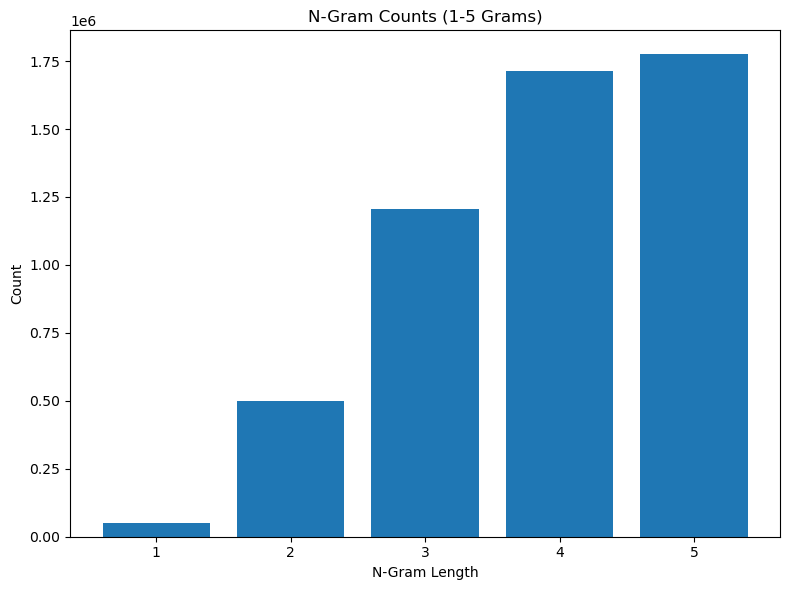

In [5]:
# Bar plot of n-gram counts 
# Extracting n-gram statistics 
ngram_stats = { 
    n: len(context_sensetive_corrector.ngram_dicts[n])
    for n in range(1, 6)
}

fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(ngram_stats.keys(), ngram_stats.values())
ax.set_title("N-Gram Counts (1-5 Grams)")
ax.set_xlabel("N-Gram Length")
ax.set_ylabel("Count")

plt.tight_layout()
plt.show()

In [6]:
test_words = [
    "speling",
    "dking",
    "fel"
]

for word in test_words:
    corrected_word = context_sensetive_corrector.correct_word(word)
    print(f"Original: {word}")
    print(f"Corrected: {corrected_word}")
    print("-" * 50)

Original: speling
Corrected: spelling
--------------------------------------------------
Original: dking
Corrected: doing
--------------------------------------------------
Original: fel
Corrected: few
--------------------------------------------------


In [7]:
test_sentences = [
    "a bad cas of the",
    "He fel in a puddle.",
    "He did not fel well."
]

for sentence in test_sentences:
    corrected_sentence = context_sensetive_corrector.correct_sentence(sentence)
    print(f"Original: {sentence}")
    print(f"Corrected: {corrected_sentence}")
    print("-" * 50)

Original: a bad cas of the
Corrected: a bad case of the
--------------------------------------------------
Original: He fel in a puddle.
Corrected: he fell in a puddle .
--------------------------------------------------
Original: He did not fel well.
Corrected: he did not feel well .
--------------------------------------------------


## 3. Evaluation

### Norvig's corrector (from https://norvig.com/spell-correct.html)

In [8]:
class NorwigCorrector:
    def __init__(self, corpus_path):
        self.unigrams = Counter(self.words(open(corpus_path).read()))

    def words(self, text):
        return re.findall(r'\w+', text.lower())

    def P(self, word):
        """Probability of `word`."""
        N = sum(self.unigrams.values())
        return self.unigrams[word] / N

    def correct_word(self, word):
        """Most probable spelling correction for word."""
        return max(self.candidates(word), key=self.P)

    def candidates(self, word):
        """Generate possible spelling corrections for word."""
        return self.known([word]) or self.known(self.edits1(word)) or self.known(self.edits2(word)) or [word]

    def known(self, words):
        """The subset of `words` that appear in the dictionary of unigrams."""
        return set(w for w in words if w in self.unigrams)

    def edits1(self, word):
        """All edits that are one edit away from `word`."""
        letters = 'abcdefghijklmnopqrstuvwxyz'
        splits = [(word[:i], word[i:]) for i in range(len(word) + 1)]
        deletes = [L + R[1:] for L, R in splits if R]
        transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R) > 1]
        replaces = [L + c + R[1:] for L, R in splits if R for c in letters]
        inserts = [L + c + R for L, R in splits for c in letters]
        return set(deletes + transposes + replaces + inserts)

    def edits2(self, word):
        """All edits that are two edits away from `word`."""
        return set(e2 for e1 in self.edits1(word) for e2 in self.edits1(e1))

    # new function to correct words in sentences
    def correct_sentence(self, sentence):
        """Corrects a given sentence by applying spelling correction to each word."""
        return ' '.join(self.correct_word(word) for word in sentence.split())

norwig_corrector = NorwigCorrector('brown_train.txt')

In [9]:
test_words = [
    "speling",
    "dking",
    "fel"
]

for word in test_words:
    corrected_word = norwig_corrector.correct_word(word)
    print(f"Original: {word}")
    print(f"Corrected: {corrected_word}")
    print("-" * 50)

Original: speling
Corrected: spelling
--------------------------------------------------
Original: dking
Corrected: doing
--------------------------------------------------
Original: fel
Corrected: few
--------------------------------------------------


In [10]:
test_sentences = [
    "a bad cas of the",
    "He fel in a puddle.",
    "He did not fel well."
]

for sentence in test_sentences:
    corrected_sentence = norwig_corrector.correct_sentence(sentence)
    print(f"Original: {sentence}")
    print(f"Corrected: {corrected_sentence}")
    print("-" * 50)

Original: a bad cas of the
Corrected: a bad was of the
--------------------------------------------------
Original: He fel in a puddle.
Corrected: he few in a puddles
--------------------------------------------------
Original: He did not fel well.
Corrected: he did not few well
--------------------------------------------------


### Evaluating correctors on word misspellings

In [11]:
def spell_correction_test_for_words(file_path, corrector, verbose=False):
    """
    Reads a test set from a file and evaluates the spelling correction model on individual words.

    Parameters:
    - file_path: Path to the test file (each line in 'correct_word: wrong1 wrong2' format)
    - corrector: Spelling correction model instance (must have a 'correct_word' method)
    - verbose: If True, outputs detailed correction information

    Outputs:
    - Displays percentage of correctly fixed words, execution speed per word.
    """
    import time

    # Read test cases from file and parse them into (correct_word, misspelled_word) pairs
    with open(file_path, 'r', encoding='utf-8') as file:
        tests = [(right.strip(), wrong.strip())
                 for line in file if ':' in line
                 for right, wrongs in [line.strip().split(':')]
                 for wrong in wrongs.strip().split()]

    start = time.time()
    good, unknown = 0, 0
    n = len(tests)

    vocab = corrector.unigrams 

    for right, wrong in tests:
        w = corrector.correct_word(wrong)
        good += (w == right)
        if w != right:
            unknown += (right not in vocab)
            
            if verbose:
                print(f'correction({wrong}) => {w} ({vocab.get(w, 0)}); expected {right} ({vocab.get(right, 0)})')

    dt = time.time() - start
    word_accuracy = good / n

     # Reports efficiency of correction model
    print(f'Accuracy: {word_accuracy:.2%}')
    print(f'Processed {n} words in {dt:.2f} seconds')
    print(f'Processing Speed: {n / dt:.2f} words per second')

#### Norvig's corrector 

In [12]:
# Development set 
spell_correction_test_for_words("spell-testset1.txt", norwig_corrector, verbose=False)

Accuracy: 72.22%
Processed 270 words in 6.12 seconds
Processing Speed: 44.08 words per second


In [13]:
# Final test set
spell_correction_test_for_words("spell-testset2.txt", norwig_corrector, verbose=False)

Accuracy: 73.50%
Processed 400 words in 9.94 seconds
Processing Speed: 40.25 words per second


#### Context sensetive corrector

In [14]:
# Development set
spell_correction_test_for_words("spell-testset1.txt", context_sensetive_corrector, verbose=False)

Accuracy: 73.33%
Processed 270 words in 6.05 seconds
Processing Speed: 44.63 words per second


In [15]:
# Final test set
spell_correction_test_for_words("spell-testset2.txt", context_sensetive_corrector, verbose=False)

Accuracy: 71.50%
Processed 400 words in 10.24 seconds
Processing Speed: 39.07 words per second


### Evaluating correctors on word misspellings within sentences

**Creating Realistic Test Data with `sage`**

To generate a **realistic test dataset** for spell correction, I used **misspelling statistics** from [`ai-forever/sage`](https://github.com/ai-forever/sage.git). This library provides **real-world typo distributions** based on phonetic, keyboard, and common spelling mistakes, making the test data more reflective of actual user errors. By leveraging these statistics, we can create **synthetic misspelled words in sentences** to evaluate and fine-tune spell correction model effectively.


In [ ]:
def corrupt_sentences_with_sage(input_file_path, output_file_path):
    """
    Generates a corrupted dataset using real-world misspelling patterns from SAGE.

    This function takes a clean text dataset and introduces realistic spelling errors
    based on statistical models from the SAGE library. It ensures that common typos
    (phonetic, keyboard, and spelling errors) are incorporated to create a robust test set.

    Parameters:
    - input_file_path: Path to the original clean dataset (each line is a sentence).
    - output_file_path: Path where the corrupted dataset will be saved.

    The function:
    - Checks if the corrupted dataset already exists to prevent redundant processing.
    - Automatically installs SAGE if missing.
    - Uses SAGE’s spelling corruption models to generate realistic typos.
    - Saves the corrupted and original sentences in a CSV file for evaluation.
    """

    if os.path.exists(output_file_path):
        print(f"Corrupted dataset already exists: {output_file_path}")
        return

    if not os.path.exists(input_file_path):
        print(f"File {input_file_path} not found! Upload it before running.")
        return

    print(f"Found {input_file_path}, processing...")

    try:
        from sage.spelling_corruption import SBSCConfig, SBSCCorruptor
    except ImportError:
        print("SAGE not found, installing...")
        os.system("git clone https://github.com/ai-forever/sage.git")
        os.chdir("sage")
        os.system("pip install -e '.[errant]' --quiet")
        from sage.spelling_corruption import SBSCConfig, SBSCCorruptor

    with open(input_file_path, "r", encoding="utf-8") as file:
        lines = [line.strip() for line in file.readlines() if line.strip()]

    print(f"Creating corrupted dataset: {output_file_path}")

    # Configure the corruptor to introduce realistic spelling errors
    config = SBSCConfig(
        lang="en",
        reference_dataset_name_or_path=os.path.join("data", "example_data", "jfleg"),
    )

    corruptor = SBSCCorruptor.from_config(config)
    corrupted_lines = corruptor.batch_corrupt(lines)

    # Save the corrupted sentences alongside their correct versions for evaluation
    df = pd.DataFrame({"corrupted_text": corrupted_lines, "corrected_text": lines})
    df.to_csv(output_file_path, index=False)

    print(f"Corrupted dataset saved as {output_file_path}")

In [ ]:
# Create a corrupted version of the Brown development test set using SAGE
corrupt_sentences_with_sage("brown_dev_test.txt", "brown_dev_test_corrupted_sentences.txt")

Corrupted dataset already exists: brown_dev_test_corrupted_sentences.txt


In [ ]:
# Create a corrupted version of the Brown test set using SAGE
corrupt_sentences_with_sage("brown_test.txt", "brown_test_corrupted_sentences.txt")

Corrupted dataset already exists: brown_test_corrupted_sentences.txt


In [ ]:
def spell_correction_test_for_sentences(file_path, corrector, verbose=False):
    """
    Evaluates a spelling correction model on full sentences using a test data.

    This function reads a CSV file containing corrupted and corrected sentences, 
    applies the spell corrector, and compares the predicted corrections against the ground truth. 
    It calculates the token-level accuracy and measures processing speed.

    Parameters:
    - file_path: Path to the CSV file with 'corrupted_text' and 'corrected_text' columns.
    - corrector: Spelling correction model instance (must have 'correct_sentence' method).
    - verbose: If True, outputs detailed correction information.

    Outputs:
    - Accuracy of word-level corrections across all sentences.
    - Processing speed in words per second and sentences per second.
    """

    df = pd.read_csv(file_path)

    required_cols = {"corrupted_text", "corrected_text"}
    if not required_cols.issubset(df.columns):
        raise ValueError(f"CSV file must contain columns: {required_cols}")

    df = df.dropna(subset=["corrupted_text", "corrected_text"])
    tokenizer = TreebankWordTokenizer()
    
    start = time.time()
    total_tokens, count = 0, 0

    # Iterates through each sentence in the dataset and applies the correction model
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Processing Sentences"):
        typo_sentence = row["corrupted_text"]
        correct_sentence = row["corrected_text"]
        
        fixed_sentence = corrector.correct_sentence(typo_sentence)

        # Tokenizes the ground truth and corrected sentence for comparison
        correct_tokens = tokenizer.tokenize(correct_sentence.lower())
        fixed_tokens = tokenizer.tokenize(fixed_sentence.lower())

        if verbose:
            print(correct_tokens)
            print(fixed_tokens)
            print([(correct_tokens[i], fixed_tokens[i]) for i in range(min(len(correct_tokens), len(fixed_tokens))) 
                   if correct_tokens[i] != fixed_tokens[i]])

        total_tokens += len(correct_tokens)

        # Counts how many words were correctly restored
        tmp_count = sum(1 for i in range(min(len(correct_tokens), len(fixed_tokens))) 
                        if correct_tokens[i] == fixed_tokens[i])
        count += tmp_count

        if verbose and total_tokens > 0:
            print(f'Correct: {correct_sentence}')
            print(f'With error:  {typo_sentence}')
            print(f'Corrected: {fixed_sentence}')
            print(f'Accuracy: {tmp_count}/{len(correct_tokens)}')
            print('-' * 50)

    dt = time.time() - start

    # Computes overall accuracy and processing speed
    accuracy = count / total_tokens if total_tokens else 0
    print(f'\nAccuracy: {accuracy:.2%}')
    print(f'Processed {len(df)} sentences in {dt:.2f} seconds')
    print(f'Processing Speed: {total_tokens / dt:.2f} words/sec, {len(df) / dt:.2f} sentences/sec')


#### Norvig's corrector 

In [21]:
# Development set 
spell_correction_test_for_sentences("brown_dev_test_corrupted_sentences.txt", norwig_corrector, verbose=False)

Processing Sentences: 100%|██████████| 2867/2867 [04:28<00:00, 10.68it/s]


Accuracy: 75.27%
Processed 2867 sentences in 268.48 seconds
Processing Speed: 216.90 words/sec, 10.68 sentences/sec


In [22]:
# Final test set
spell_correction_test_for_sentences("brown_test_corrupted_sentences.txt", norwig_corrector, verbose=False)

Processing Sentences: 100%|██████████| 8601/8601 [13:22<00:00, 10.72it/s]


Accuracy: 75.17%
Processed 8601 sentences in 802.16 seconds
Processing Speed: 219.57 words/sec, 10.72 sentences/sec


#### Context sensetive corrector 

In [23]:
# Development set
spell_correction_test_for_sentences("brown_dev_test_corrupted_sentences.txt", context_sensetive_corrector, verbose=False)

Processing Sentences: 100%|██████████| 2867/2867 [16:43<00:00,  2.86it/s]  


Accuracy: 97.19%
Processed 2867 sentences in 1003.25 seconds
Processing Speed: 58.05 words/sec, 2.86 sentences/sec


In [24]:
# Final test set
spell_correction_test_for_sentences("brown_test_corrupted_sentences.txt", context_sensetive_corrector, verbose=False)

Processing Sentences: 100%|██████████| 8601/8601 [52:49<00:00,  2.71it/s]   


Accuracy: 97.12%
Processed 8601 sentences in 3169.46 seconds
Processing Speed: 55.57 words/sec, 2.71 sentences/sec


## 4. Results

I evaluated two spell correction models on various test datasets, focusing on word-level and sentence-level corrections. All results here are based on the final test set.

### Word-Level Evaluation

The word-level evaluation focuses on correcting individual words. The following table presents the accuracy of each model on the final test set.

| Model                    | Final Test Set Accuracy | Processed Words | Time (Seconds) | Processing Speed (words/sec) |
|--------------------------|-------------------------|-----------------|----------------|-----------------------------|
| Norvig Corrector           | 73.50%                  | 400             | 9.94           | 40.25                       |
| Context-Sensitive Corrector                | 71.50%                  | 400             | 10.24          | 39.07                       |

The **Norvig Corrector** achieves a slightly higher accuracy compared to **Context-Sensitive Corrector**. However, the processing speed for both models is relatively similar, with Norvig’s corrector processing words a bit faster.

### Sentence-Level Evaluation

For sentence-level evaluation, I evaluated how well each model can correct sentences with multiple typos. The accuracy of corrections was calculated based on token-level matches between the ground truth and the corrected sentences. The table below shows the results of this evaluation.

| Model                    | Final Test Set Accuracy | Processed Sentences | Time (Seconds) | Processing Speed (sentences/sec) |
|--------------------------|-------------------------|---------------------|----------------|---------------------------------|
| Norvig Corrector           | 75.17%                  | 8601                | 802.16         | 10.72                           |
| Context-Sensitive Corrector  | 97.12%                  | 8601                | 3169.46        | 2.71                            |

The **Context-Sensitive Corrector** demonstrates a much higher accuracy at the sentence level, although it processes sentences slower than Norvig's model, likely due to the more complex correction approach employed by **Context-Sensitive Corrector**.

### Summary

In summary, **Norvig Corrector** performs better in terms of speed, both at the word and sentence levels. However, **Context-Sensitive Corrector** significantly outperforms **Norvig Corrector** in terms of accuracy, especially at the sentence level. The trade-off between processing speed and accuracy should be considered based on the application requirements.


## 5. Future work

There are several promising directions that can build upon this work and improve spell correction models:

### 1. Enhancing N-gram-Based Corrections with Interpolation  
One possible improvement is incorporating **interpolation techniques** from [Jurafsky & Martin’s Speech and Language Processing](https://web.stanford.edu/~jurafsky/slp3/3.pdf). Interpolation allows the model to combine **higher-order n-grams (e.g., trigrams, 4-grams) with lower-order ones** (e.g., unigrams, bigrams) to mitigate **data sparsity issues** and improve correction accuracy. By applying **linear interpolation strategies**, this approach could lead to more reliable word predictions in cases where n-grams are missing or underrepresented in the dataset. Other methods are also can be considered to improve the solution.

### 2. Exploring Grammar Correction as a Related Task  
While this work focused on **spelling correction**, similar methods might be useful for **grammar correction** as well. Since grammatical errors often involve **misplaced or incorrect words**, n-gram probability models and ranking methods could potentially correct **both spelling and grammar mistakes**. Testing this approach on datasets like the [Kaggle Grammar Correction Dataset](https://www.kaggle.com/datasets/satishgunjal/grammar-correction) would provide valuable insights into its feasibility.

### 3. Evaluating on Real-Life Multilingual Datasets  
To ensure broader applicability, this approach can be trained and tested on **real-world misspelling datasets** in different languages:
- **Croatian:** The [Ispravi-Me dataset](https://github.com/Ispravi-Me/Dataset-of-Misspelings-and-Corrections) contains naturally occurring spelling errors and corrections.
- **Russian:** The [AI-Forever Spellcheck Benchmark](https://huggingface.co/datasets/ai-forever/spellcheck_benchmark) provides real-life Russian misspellings.  
Applying this method to different languages would help evaluate its generalizability and uncover language-specific error patterns.

### 4. Creating a High-Quality Benchmark for English Spelling Correction  
There are many multilingual datasets available, but a **strong benchmark for English spelling correction** is still lacking. By leveraging **real-world typo distributions and user-generated errors**, a high-quality dataset could be created to:
- **Evaluate and compare** different spell correction methods fairly.
- Provide a **standardized test set** for future research.
- Reflect **realistic typing and spelling errors**, making corrections more useful for practical applications.

Each of these areas represents a separate yet **complementary direction** for improving spell correction, from **algorithmic refinements to multilingual adaptability and dataset creation**.
